<a href="https://colab.research.google.com/github/DeepankarAcharyya/Time_Series_Data/blob/master/Time_Series_Analysis_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

In [0]:
from  scipy.optimize import minimize
import statsmodels as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

Error Metric:

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred)/ y_true))*100

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%matplotlib inline

In [0]:
data=pd.read_csv('TATAPOWER.NS.csv', index_col=['Date'], parse_dates=['Date'])

In [10]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-03,69.000000,69.250000,67.750000,68.349998,65.743179,4792922.0
2019-06-04,67.500000,68.000000,66.449997,66.699997,65.400002,4864404.0
2019-06-06,66.750000,66.949997,64.650002,65.099998,65.099998,4982307.0
2019-06-07,65.000000,66.599998,64.050003,66.300003,66.300003,4984037.0
2019-06-10,66.650002,67.300003,65.949997,66.550003,66.550003,4586585.0


Cleaning the Data:

In [9]:
drop_cols=['Adj Close', 'Volume']

data.drop(drop_cols, axis=1, inplace=True)

data.head()

,Open,High,Low,Close
Date,,,,
2019-06-03,69.000000,69.250000,67.750000,68.349998
2019-06-04,67.500000,68.000000,66.449997,66.699997
2019-06-06,66.750000,66.949997,64.650002,65.099998
2019-06-07,65.000000,66.599998,64.050003,66.300003
2019-06-10,66.650002,67.300003,65.949997,66.550003


Exploratory Data Analysis (EDA) :

In [11]:
for cols in data.columns:
  print(cols," ", data[cols].nunique()," Null Values: ", data[cols].isnull().sum())

Open   185  Null Values:  1
High   188  Null Values:  1
Low   192  Null Values:  1
Close   195  Null Values:  1
Adj Close   195  Null Values:  1
Volume   243  Null Values:  1


In [0]:
data=data.dropna()

In [13]:
for cols in data.columns:
  print(cols," ", data[cols].nunique()," Null Values: ", data[cols].isnull().sum())

Open   185  Null Values:  0
High   188  Null Values:  0
Low   192  Null Values:  0
Close   195  Null Values:  0
Adj Close   195  Null Values:  0
Volume   243  Null Values:  0


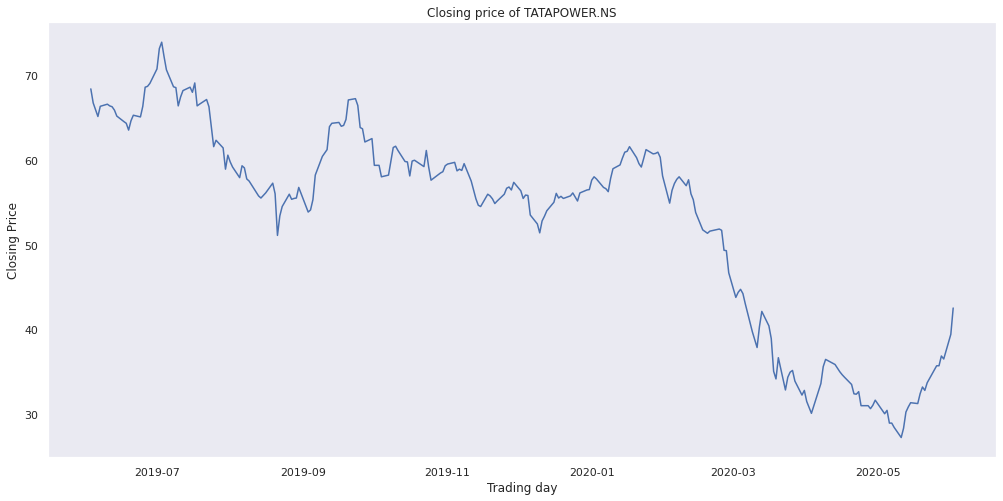

In [14]:
#plotting the closing price
plt.figure(figsize=(17,8))
plt.plot(data.Close)
plt.title('Closing price of TATAPOWER.NS')
plt.ylabel('Closing Price')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

- This is not a stationary process
- Hard to tell about the seasonality

Moving Average:

In [0]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)


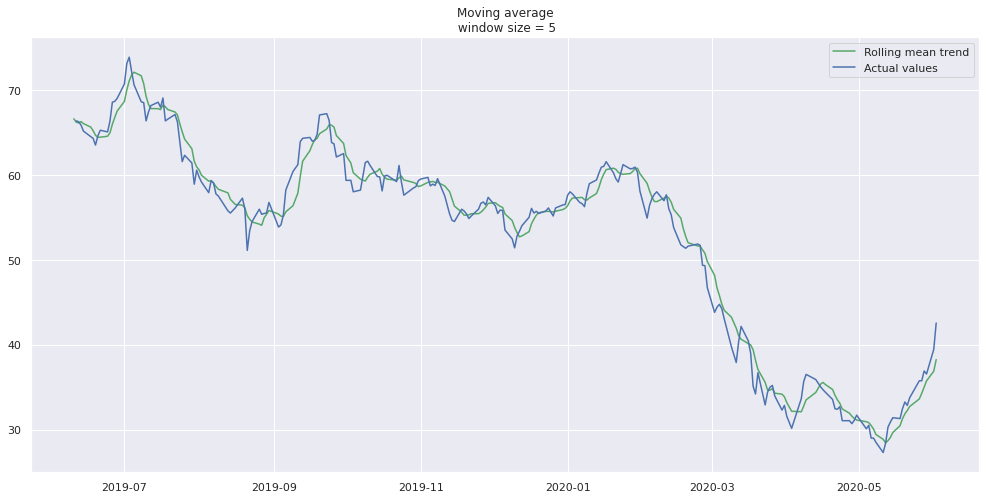

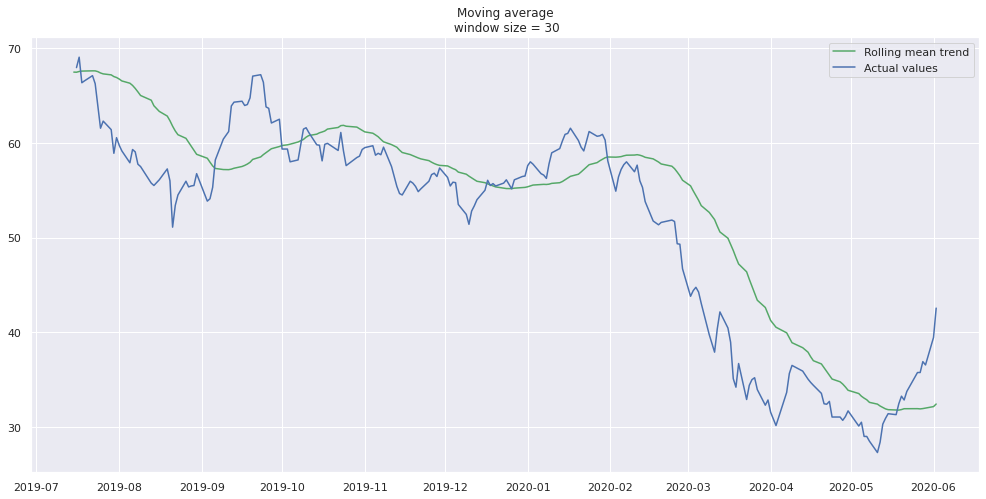

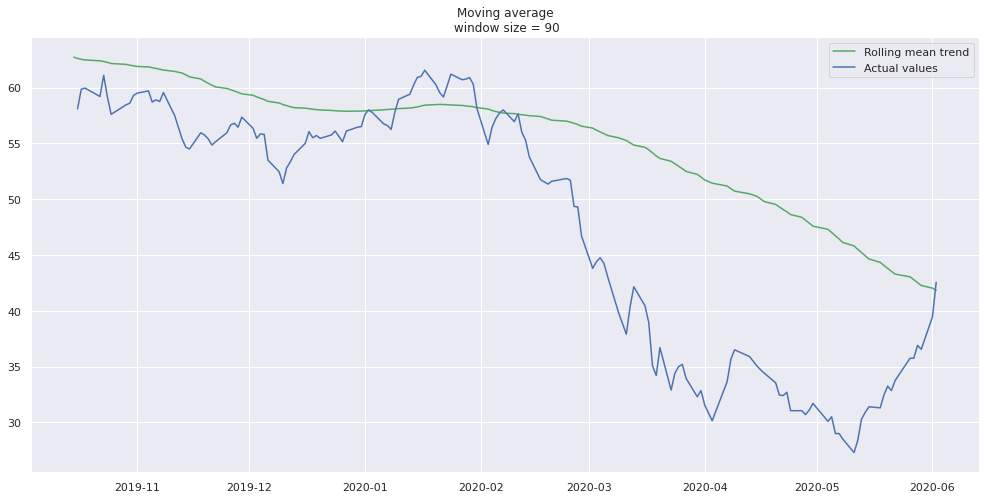

In [20]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90)

* The larger the window size, smoother the curve 
> * Easier to spot the trend

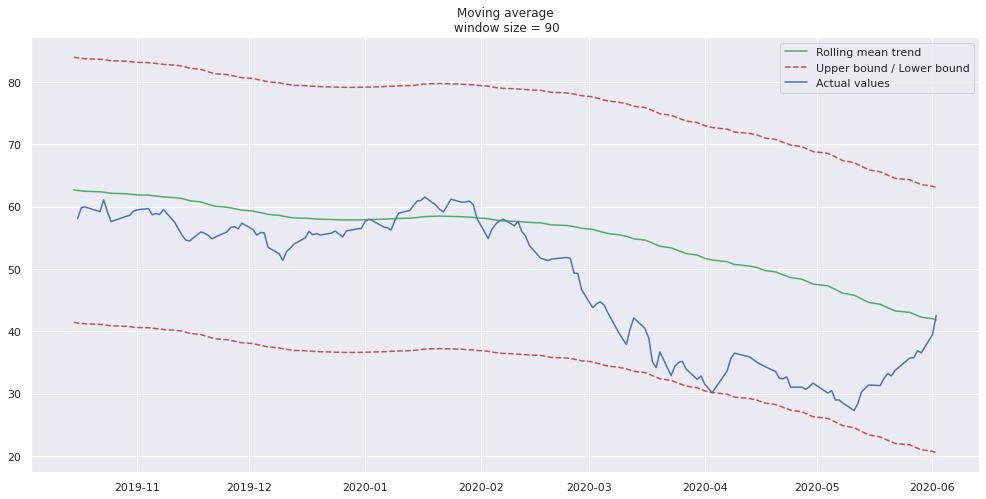

In [22]:
plot_moving_average(data.Close, 90, plot_intervals=True)

Exponential Smoothing: 

In [0]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [0]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

* alpha value 0.1 makes its easier to pick up the trend

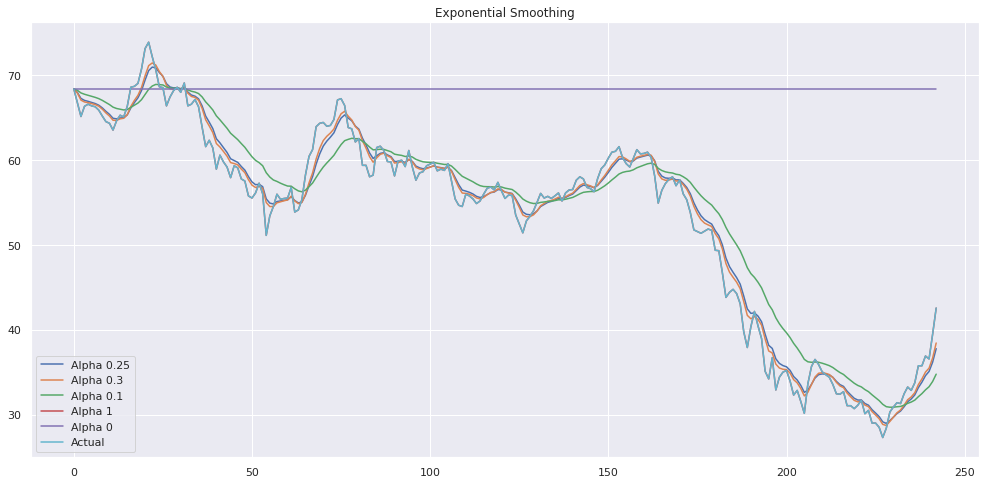

In [29]:
plot_exponential_smoothing(data.Close, [0.25, 0.3 , 0.1, 1,0])

Double Exponential Smoothing:

In [0]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [0]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

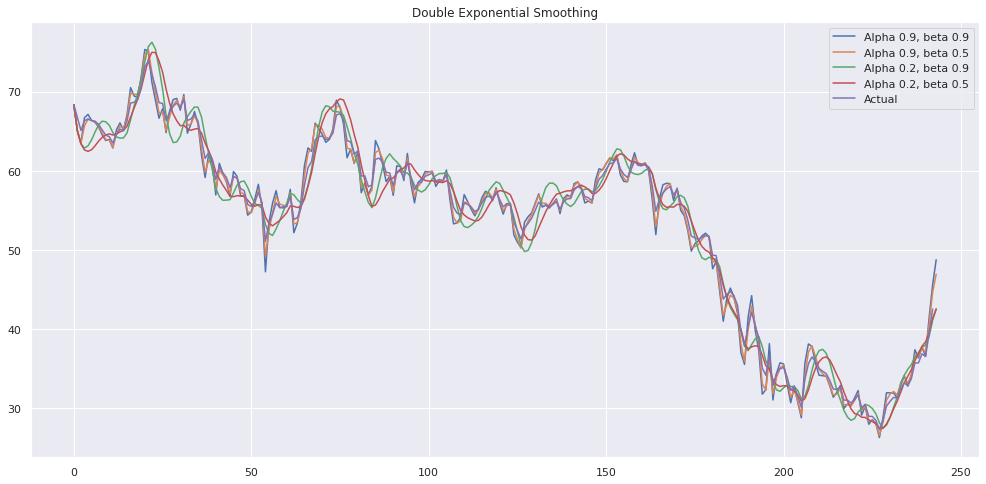

In [35]:
plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.2], betas=[0.9, 0.5])

Dickey-Fuller test to see if it is a stationary process:

In [0]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

* High autocorelation
* No clear seasonality

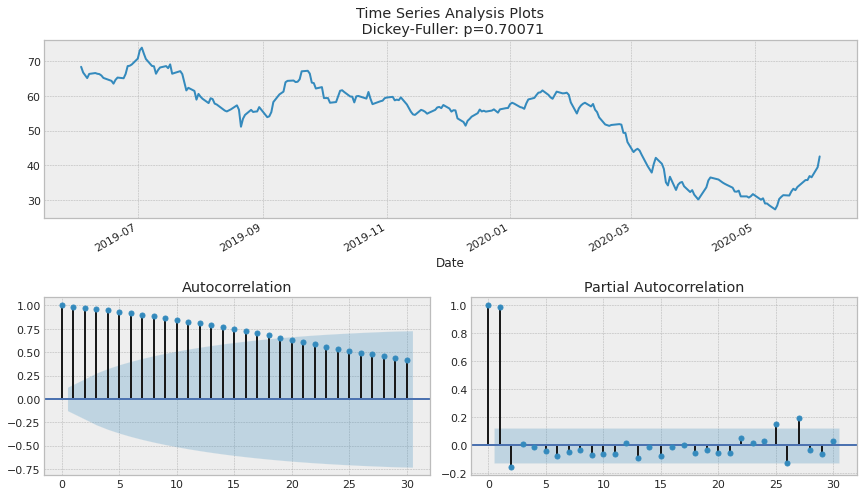

In [45]:
tsplot(data.Close, lags=30)

* subtract the time series from itself with a lag of one day
> * and we have a stationary process

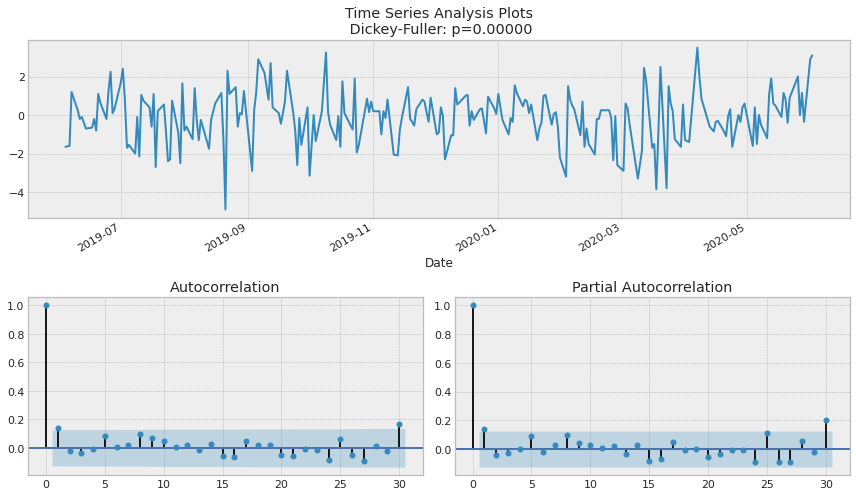

In [46]:
# Take the first difference to remove to make the process stationary
data_diff = data.Close - data.Close.shift(1)
tsplot(data_diff[1:], lags=30)

In [47]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [49]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 0, 4),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 1, 4),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 2, 4),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 0, 3, 4),
 (0, 0, 4, 0),
 (0, 0, 4, 1),
 (0, 0, 4, 2),
 (0, 0, 4, 3),
 (0, 0, 4, 4),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 0, 4),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 1, 4),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 2, 4),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 1, 3, 4),
 (0, 1, 4, 0),
 (0, 1, 4, 1),
 (0, 1, 4, 2),
 (0, 1, 4, 3),
 (0, 1, 4, 4),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 0, 4),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 1, 4),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 2, 4),
 (0, 2, 3, 0),
 (0, 2, 3,

In [0]:
# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Close, order=(param[0], d, param[1]),seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [54]:
result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Close, order=(p, d, q),seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                  243
Model:             SARIMAX(0, 1, 1)x(2, 1, 3, 5)   Log Likelihood                -407.007
Date:                           Wed, 03 Jun 2020   AIC                            828.015
Time:                                   20:26:20   BIC                            852.291
Sample:                                        0   HQIC                           837.800
                                           - 243                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1651      0.054      3.030      0.002       0.058       0.272
ar.S.L5       -0.1687      0.090     -1.87